# Errors in TPR Unbinding
-----
#### Paul Smolensky and Coleman Haley

In this notebook, we provide theoretical and experimental results on the error rate of TPR binding. We show that this error is bounded in a theoretical worst case, that this theoretical error is experimentally validated, and that empirically error appears to be lower in cases other than the theoretical worse case. We consider experiments for empirical error in the case of totally random distribution of bound vectors, as well as distributions from real-world applications of TPRs in the domain of natural language processing. We show that the error increases nicely (:P) as a function of the ratio of filler vectors to role vectors.

## 1.    Setting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline 
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets

We assume a random set of $k+1$ role vectors $\{\hat{r}_i\}^k_{i=0}$ (independently uniformly distributed on the unit sphere $S^{n-1}\subset\mathbb{R}^n$) has been chosen (from among a possibly much larger set of possible roles $\mathcal{R}$):
\begin{equation}
\hat{\mathbf{r}}_i\sim\mathcal{U}(S^{n-1})\;\;i.i.d.\;\;i=0,...,k
\end{equation}


In [22]:

# https://stackoverflow.com/questions/33976911/generate-a-random-sample-of-points-distributed-on-the-surface-of-a-unit-sphere
def sample_spherical(npoints, ndim):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)

    return vec

#rhats = sample_spherical(npoints=k+1, ndim=n)

In [27]:
def torch_sample_spherical(npoints, ndim, nsamples):
    vecs = torch.randn(ndim, npoints, nsamples)
    vecs /= torch.norm(vecs, dim=0)
    
    return vecs

and for each role $\hat{\mathbf{r}}_i$ a unit-norm filler vector $\hat{\mathbf{f}}_i$ has been chosen from among an inventory of $N$ possibilities $\mathcal{F}=\{\hat{\mathbf{f}}_j\}^{N}_{j=1}\subset\mathbb{R}^d$. We are mostly interested in the case $n \gg 1, k \gg 1, k < n$. The resulting TPR for this role/filler structure is:
\begin{equation}
\mathbf{T} = \sum^{k}_{i=0} \hat{\mathbf{f}}_i \otimes \hat{\mathbf{r}}_i \in \mathbb{R}^d \otimes \mathbb{R}^n
\end{equation}

In [4]:
# def TPR(fillers, roles):
#     # roles and need to be passed in an order such that the i-th role should be bound to the i-th filler
#     T = sum([np.outer(fillers[i], rhats[i]) for i in range(len(fillers))])
#     return T

Our question concerns retrieving or undbinding the filler of a given role $\hat{\mathbf{r}}_0$. We assume retrieval/unbinding by the inner product; the retrieved vector $\tilde{\mathbf{f}}$ is
\begin{align}
\tilde{\mathbf{f}} &= \mathbf{T} \cdot \hat{\mathbf{r}}_{0} \\
                   &= \hat{\mathbf{f}}_0 + \sum^k_{i=1}(\hat{\mathbf{r}}_i \cdot \hat{\mathbf{r}}_0)\hat{\mathbf{f}}_i
\end{align}
Let the correct result be denoted $\hat{\mathbf{A}}: \hat{\mathbf{f}}_0 = \hat{\mathbf{A}}$. Thus the undesired fillers $\hat{\mathbf{f}}_i, i > 0$  *intrude* into the retrieval of the correct filler $\hat{\mathbf{A}}$.

If $\{\hat{\mathbf{f}}_i\}_i$ is widely scattered on $S^{d-1}$, then for each of the $d$ components of the sum in (4) (NOTE: HAVEN'T FIGURED OUT NUMBERING) there will be cancellation.

## 2. Theoretical Note: Type 1 Error

TO BE COPIED FROM THE ORIGINAL DOC.

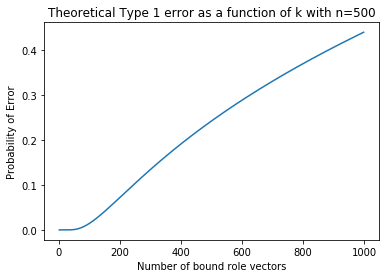

In [7]:
import math
n=500 # dimension of role vectors
ks = np.array(range(1,1000)) # k is the number of bindings
perror = np.exp(-n/(2*ks))/(np.sqrt(2*math.pi*n/ks))

plt.plot(ks,perror)

plt.title('Theoretical Type 1 error as a function of k with n=500')
plt.xlabel('Number of bound role vectors')
plt.ylabel('Probability of Error')

plt.show()

## 3. Type 1 Error, Empirically

We can validate this theoretical bound with an empirical experiment, using an approach we will extend to estimate error probabilities for other theoretical and real-world scenarios in which it is harder to obtain an appropriate bound. We do this by performing a concrete number of random samples of role vectors and which roles are bound to them and then calculating the number of errors made, repeating the process several times to get an estimate of error probability. We also once random sample filler vectors, but we do not resample the vectors themselves, as there are many fillers and unbinding performance does not generally depend on their distribution.

In [10]:

d = 200
N = 50
F = vec = sample_spherical(N, d) # zipf distribution?

NameError: name 'sample_spherical' is not defined

2.921717257230346
2.921717257230346
-0.14136601662516923
-0.09526533132069444
-0.20442350069867396
-0.0638091359044524
0.006884325977282897
-0.05924963711932742
-0.05797125920871801
-0.10601404714966597
0.005488417011272484
0.06691301125386505
-0.05645444278459542
0.025314687536917062
-0.15699038183974515
-0.32426805152620497
-0.02600723609316077
-0.000820277833441988
-0.03487410203529159
-0.040000672123602


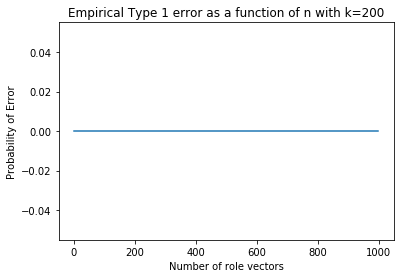

In [25]:

x3 = np.array(range(1,1000))
y3 = np.zeros(1000)
k = 200
nsamples = 1
F = vec = sample_spherical(N, d) # zipf distribution?
for n in range(1, 1000, 100):
    #if n-1%100==0:
    error_c = 0
    for sample in range(nsamples):
        rhats = sample_spherical(npoints=k+1, ndim=n)
        other = np.random.randint(0, N)
        fillers = [np.random.randint(0, N) if _==0 else other  for _ in range(k)] # type 1 error
        T = sum([np.outer(F[:,fillers[i]], rhats[:,i]) for i in range(k)]) # may choose non-distinct vectors
        print(T[0,0])
        A_hat = F[:, fillers[0]]
        
        f_tilde = np.inner(T, rhats[:,0])
        print(f_tilde[0])
        closest = max(F.T, key=lambda f:np.inner(f_tilde, f))
        if fillers[0]!=np.where(F.T==closest)[0][0]:
            error_c += 1
    y3[k-1] = error_c / nsamples


plt.plot(x3,y3[:999])
plt.title('Empirical Type 1 error as a function of n with k=200')
plt.xlabel('Number of role vectors')
plt.ylabel('Probability of Error')
plt.show()

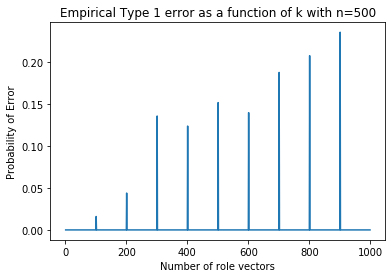

In [6]:
type1_results = np.load('type1_results.npy')
x1 = np.array(range(1,1000))
plt.plot(x1,type1_results[:999])
plt.title('Empirical Type 1 error as a function of k with n=500')
plt.xlabel('Number of role vectors')
plt.ylabel('Probability of Error')
plt.show()

## 4. Type 2 Error

We might consider a less constrained case than Type 1 error, which we will call Type 2 error. Whereas in Type 1 error all roles besides the one being unbound are filled with the same filler, causing maximal instrusion into the unbound vector in that direction, in Type 2 error, we make no such assumptions about the other role-filler bindings, assuming that all are chosen at random. In this case, it is difficult to provide a theoretical estimate of error probability. Therefore, we apply the strategy from the preceeding experiment to obtain an empirical estimate.

In [8]:
%%time
x1 = np.array(range(1,1000))
y1 = np.zeros(999)
n = 500
nsamples = 2000
nfillers=50
fillerdim=k
F = vec = sample_spherical(npoints=nfillers, ndim=fillerdim, nsamples=1) # zipf distribution?
print(F[50][1])
for k in range(100,1000,100):
    error_c = 0
    rhats = tosample_spherical(npoints=k+1, ndim=n, nsamples=nsamples)
    fillers = torch.randint(0, N, (k, nsamples)) #type 2 error
#     T = 
    T = sum([np.outer(F[:,fillers[i]], rhats[:,i]) for i in range(k)]) # may choose non-distinct vectors
    A_hat = F[:, fillers[0]]

    f_tilde = np.inner(T, rhats[:,0])
    print(f_tilde[0])
    closest = max(F.T, key=lambda f:np.inner(f_tilde, f))
    if fillers[0]!=np.where(F.T==closest)[0][0]:
        error_c += 1
    y1[k-1] = error_c / 250


plt.plot(x1,y1)
plt.title('Empirical Type 2 error as a function of k with n=500')
plt.xlabel('Number of role vectors')
plt.ylabel('Probability of Error')
plt.show()

NameError: name 'k' is not defined

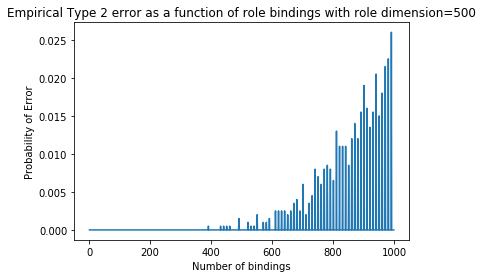

In [69]:
type2_results = np.load('type2_results.npy')
x1 = np.array(range(1,1000))
plt.plot(x1,type2_results)
plt.title('Empirical Type 2 error as a function of role bindings with role dimension=500')
plt.xlabel('Number of bindings')
plt.ylabel('Probability of Error')
plt.show()

## 5. Error in the real world.

While these theoretical scenarios are useful to think about, they don't exactly match the real-world problems encountered when using TPRs. In the real world, fillers for roles should not be thought of as being drawn in a uniform distribution, but some fillers may be much more common than others. For instance, in a natural language context where our fillers are words, we might expect them to be drawn from a Zipf distribution. Further, conditioning on a single TPR, we might expect additional correlation between the fillers in the same TPR, due to, for example, syntactic and semantic constraints. Finally, we might also consider that the vector representations of co-occuring fillers might be expected to have a greater similarity than filler vectors chosen totally at random, and the filler space might be extremely dense. In this section, we explore these problems in the context of positional sentence TPRs with word2vec embeddings as fillers, using the reuters corpus as the source for sentences to be embedded and GoogleNews vectors as the embedding vectors.

In [3]:
import nltk
nltk.download('reuters')
nltk.download('punkt')

[nltk_data] Downloading package reuters to /Users/coleman/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /Users/coleman/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### 5.1 Preprocessing

In [17]:
from nltk.corpus import reuters
from gensim.models import KeyedVectors
sents = list(reuters.sents())
sents.sort(key=len)

In [16]:
print(sents)

[]


In [18]:
bound = 0
while len(sents[bound+1]) <=50:
    bound += 1
    
# bound = next(i for i in range(len(sents)) if len(sents[i])<=50) # take only sentences of length 50 or less

In [19]:
# constrain upper length of sentences to have a fixed role set.
sents = sents[:bound] # the sentences of length 50 or less
print('%d sentences.' % (len(sents)))

49442 sentences.


In [6]:
wordvecs = KeyedVectors.load_word2vec_format('./model/GoogleNews-vectors-negative300.bin', binary=True) 

In [30]:
# remove OOV words and sentences of length 0.
len0sents = []
for sent in sents:
    toremove = []
    for word in sent:
        try:
            wordvecs[word]
        except KeyError:
            toremove.append(word)
    for word in toremove:
        sent.remove(word)
    if len(sent) == 0:
        len0sents.append(sent)

for sent in len0sents:
    sents.remove(sent)
    
print('%d sentences.' % (len(sents)))

49433 sentences.


In [184]:
# not enough! gotta run faster
num_sents_per_len = [sum(1 if len(sent)==i else 0 for sent in sents[::500]) for i in range(1,50)]
print(num_sents_per_len)

[1, 0, 0, 1, 1, 1, 1, 2, 6, 3, 1, 3, 4, 5, 3, 3, 3, 5, 5, 6, 1, 3, 6, 3, 3, 4, 4, 7, 2, 0, 2, 3, 2, 0, 0, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### 5.2 Statistical properties of Google News vectors

In [32]:
# Average dot product between word2vec reps of words of the last sentence in the corpus
sum([sum([np.inner(wordvecs[w1],wordvecs[w2]) for w1 in sents[-1]])/len(sents[-1]) for w2 in sents[-1]])/len(sents[-1])

0.6487857584178377

In [33]:
# Notice they're not normalized:
np.inner(wordvecs[sents[0][0]],wordvecs[sents[0][0]])

4.037166

In [145]:
# random 300 dimensional unit vectors
avg = 0
for sample in range(100):
    
    rhats = sample_spherical(npoints=len(sents[-1]), ndim=300)
    avg += sum([sum([np.inner(rhati,rhatj) for rhati in rhats])/len(sents[-1]) for rhatj in rhats])/len(sents[-1])
avg = avg / 100
print(avg)

0.028437374385665806


In [146]:
sum([sum([np.inner(wordvecs[w1],wordvecs[w2]) for w1 in sents[-1]])/len(sents[-1]) for w2 in sents[-1]])/len(sents[-1]) / avg

23.012637710747804

In [134]:
# Is this a general property of word2vec, or the words being from the same sentence?
sum([sum([np.inner(wordvecs[w1],wordvecs[w2]) for w1 in sents[-1]])/len(sents[-1]) for w2 in sents[-5]])/len(sents[-5])

0.4411893014964604

In [137]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [164]:
%%time
nfilledroles = np.array(range(1,50))
errors = np.zeros(49)
nsamples = 1
ndim=50
bests = []
trues = []
for sample in range(nsamples):
    rhats = sample_spherical(npoints=50, ndim=ndim)
    processed_sents = 0
    for sent in sents[::500]:
        print(sent)
        kp1 = len(sent) # k+1: the number of filled role vectors
        error_c = 0
        fillers = [wordvecs[sent[i]] for i in range(kp1)]
        roles = [rhats[:, i] for i in range(kp1)]
        T = sum([np.outer(wordvecs[sent[i]], rhats[:,i]) for i in range(kp1)]) # take TPR
        sbests = []
        strues = []
        for i in range(kp1):
            A_hat = fillers[i] # correct filler
            f_tilde = np.inner(T, roles[i])
            topi.append([])
            strues.append(A_hat)
            # solution is the vector with largest dot product with f_tilde
            closeness = np.einsum('ij, j->i', wordvecs.vectors, f_tilde)
            for i in range(25): # num topi
                topi.append(wordvecs.vectors[np.argpartition(closeness, kth=i)[i]])
            closest = topi[0]
            # print(np.where(fillers==closest)[0][0]) # am I sure about this np.where?
            if not np.array_equal(A_hat, closest):
                error_c += 1
            sbests.append(topi)
        trues.append(strues)
        errors[kp1-1] += error_c / kp1
        processed_sents += 1
        bests.append(sbests)
#         if processed_sents%10000 == 0:
#             print(processed_sents)


['REUTER']
['Terms', 'were', 'not', 'disclosed']
['Western', 'diplomatic', 'sources', 'were', 'more', 'blunt']
['Funds', 'averaged', '6', 'pct', 'yesterday']
['It', 'would', 'depend', 'on', 'what', 'price', 'they', 'offered']
['Shultz', 'is', 'set', 'arrive', 'in', 'Moscow', 'April']
['Gabelli', 'is', 'an', 'investment', 'firm', 'headquartered', 'in', 'New', 'York', 'City']
['Leader', 'said', 'the', 'stock', 'is', 'convertible', 'into', 'common']
['The', 'capital', 'increase', 'will', 'boost', 'our', 'operations', 'she', 'said']
['Victor', 'was', 'stock', 'association', 'with', 'mln', 'dlrs', 'in', 'assets']
['MURPHY', 'OIL', 'SAID', 'IT', 'PROPOSING', 'TO', 'ACQUIRE', 'REMAINING', 'PCT', 'OF', 'CANADIAN', 'SUBSIDIARY']
['BORG', 'WARNER', 'TO', 'SELL', 'INDUSTRIAL', 'PRODUCTS', 'BUSINESS', 'FOR', 'ABOUT', 'MLN']
['First', 'quarter', 'exports', 'rose', 'pct', '9', '4', 'billion', 'dlrs']
['The', 'fall', 'compares', 'with', 'decline', '0', '2', 'pct', 'in', 'December']
['The', 'MITI', 'o

['World', 'cereal', 'stocks', 'at', 'the', 'end', 'were', 'forecast', 'rise', 'mln', 'tonnes', 'record', 'mln', 'tonnes', 'softening', 'the', 'impact', 'reduced', 'production']
['This', 'development', 'was', 'aided', 'by', 'cooperation', 'between', 'the', 'bank', 'the', 'savings', 'banks', 'in', 'the', 'West', 'German', 'state', 'North', 'Rhine', 'Westphalia', 'where', 'parent', 'bank', 'WestLB', 'is', 'based']
['These', 'certificates', 'will', 'provide', 'ample', 'free', 'supplies', 'corn', 'wheat', 'for', 'the', 'remainder', 'the', 'crop', 'year', 'the', 'department', 'said', 'in', 'summary', 'its', 'Agricultural', 'Outlook', 'report']
['Paul', 'Cain', 'vice', 'president', 'at', 'Shearson', 'Lehman', 'Brothers', 'said', 'the', 'elimination', 'price', 'limits', 'will', 'cut', 'back', 'on', 'panic', 'buying', 'or', 'selling', 'contribute', 'more', 'orderly', 'markets']
['Beall', 'said', 'the', 'recent', 'trend', 'toward', 'cost', 'sharing', 'in', 'the', 'research', 'development', 'phas

['EC', 'U', 'S', 'PLAN', 'HIGH', 'LEVEL', 'TRADE', 'TALKS', 'The', 'European', 'Community', 'is', 'willing', 'offer', 'limited', 'concessions', 'the', 'United', 'States', 'on', 'one', 'two', 'major', 'issues', 'which', 'threaten', 'poison', 'their', 'trade', 'relations', 'next', 'year', 'an', 'EC', 'commission', 'spokesman', 'said']
['Sosnoff', 'said', 'in', 'the', 'newspaper', 'advertisement', 'that', 'the', 'amended', 'offer', 'is', 'conditioned', 'on', 'receipt', 'enough', 'shares', 'give', 'him', 'majority', 'interest', 'on', 'fully', 'diluted', 'basis', 'on', 'the', 'arrangement', 'financing', 'as', 'well', 'as', 'approvals', 'by', 'New', 'Jersey', 'Nevada', 'gaming', 'authorities']
['Siew', 'said', 'the', 'talks', 'starting', 'on', 'April', 'would', 'cover', 'U', 'S', 'Calls', 'for', 'Taiwan', 'open', 'its', 'market', 'American', 'products', 'purchases', 'major', 'U', 'S', 'Machinery', 'power', 'plant', 'equipment', 'import', 'tariff', 'cuts', 'protection', 'intellectual', 'prope

In [165]:
%%time
nfilledroles = np.array(range(1,50))
berrors = np.zeros(49)
nsamples = 1
ndim=50
bests = []
trues = []
for sample in range(nsamples):
    rhats = sample_spherical(npoints=50, ndim=ndim)
    processed_sents = 0
    for sent in sents[::500]:
        print(sent)
        kp1 = len(sent) # k+1: the number of filled role vectors
        error_c = 0
        fillers = [wordvecs[sent[i]] for i in range(kp1)]
        roles = [rhats[:, i] for i in range(kp1)]
        T = sum([np.outer(wordvecs[sent[i]], rhats[:,i]) for i in range(kp1)]) # take TPR
        sbests = []
        strues = []
        for i in range(kp1):
            A_hat = fillers[i] # correct filler
            f_tilde = np.inner(T, roles[i])
            topi.append([])
            strues.append(A_hat)
            # solution is the vector with largest dot product with f_tilde
            closeness = np.einsum('ij, j->i', wordvecs.vectors, f_tilde)
            for i in range(50): # num topi
                topi.append(wordvecs.vectors[np.argpartition(closeness, kth=i)[i]])
            closest = topi[0]
            # print(np.where(fillers==closest)[0][0]) # am I sure about this np.where?
            if not np.array_equal(A_hat, closest):
                error_c += 1
            sbests.append(topi)
        trues.append(strues)
        errors[kp1-1] += error_c / kp1
        processed_sents += 1
        bests.append(sbests)
#         if processed_sents%10000 == 0:
#             print(processed_sents)

['REUTER']
['Terms', 'were', 'not', 'disclosed']
['Western', 'diplomatic', 'sources', 'were', 'more', 'blunt']
['Funds', 'averaged', '6', 'pct', 'yesterday']
['It', 'would', 'depend', 'on', 'what', 'price', 'they', 'offered']
['Shultz', 'is', 'set', 'arrive', 'in', 'Moscow', 'April']
['Gabelli', 'is', 'an', 'investment', 'firm', 'headquartered', 'in', 'New', 'York', 'City']
['Leader', 'said', 'the', 'stock', 'is', 'convertible', 'into', 'common']
['The', 'capital', 'increase', 'will', 'boost', 'our', 'operations', 'she', 'said']
['Victor', 'was', 'stock', 'association', 'with', 'mln', 'dlrs', 'in', 'assets']
['MURPHY', 'OIL', 'SAID', 'IT', 'PROPOSING', 'TO', 'ACQUIRE', 'REMAINING', 'PCT', 'OF', 'CANADIAN', 'SUBSIDIARY']
['BORG', 'WARNER', 'TO', 'SELL', 'INDUSTRIAL', 'PRODUCTS', 'BUSINESS', 'FOR', 'ABOUT', 'MLN']
['First', 'quarter', 'exports', 'rose', 'pct', '9', '4', 'billion', 'dlrs']
['The', 'fall', 'compares', 'with', 'decline', '0', '2', 'pct', 'in', 'December']
['The', 'MITI', 'o

['World', 'cereal', 'stocks', 'at', 'the', 'end', 'were', 'forecast', 'rise', 'mln', 'tonnes', 'record', 'mln', 'tonnes', 'softening', 'the', 'impact', 'reduced', 'production']
['This', 'development', 'was', 'aided', 'by', 'cooperation', 'between', 'the', 'bank', 'the', 'savings', 'banks', 'in', 'the', 'West', 'German', 'state', 'North', 'Rhine', 'Westphalia', 'where', 'parent', 'bank', 'WestLB', 'is', 'based']
['These', 'certificates', 'will', 'provide', 'ample', 'free', 'supplies', 'corn', 'wheat', 'for', 'the', 'remainder', 'the', 'crop', 'year', 'the', 'department', 'said', 'in', 'summary', 'its', 'Agricultural', 'Outlook', 'report']
['Paul', 'Cain', 'vice', 'president', 'at', 'Shearson', 'Lehman', 'Brothers', 'said', 'the', 'elimination', 'price', 'limits', 'will', 'cut', 'back', 'on', 'panic', 'buying', 'or', 'selling', 'contribute', 'more', 'orderly', 'markets']
['Beall', 'said', 'the', 'recent', 'trend', 'toward', 'cost', 'sharing', 'in', 'the', 'research', 'development', 'phas

['EC', 'U', 'S', 'PLAN', 'HIGH', 'LEVEL', 'TRADE', 'TALKS', 'The', 'European', 'Community', 'is', 'willing', 'offer', 'limited', 'concessions', 'the', 'United', 'States', 'on', 'one', 'two', 'major', 'issues', 'which', 'threaten', 'poison', 'their', 'trade', 'relations', 'next', 'year', 'an', 'EC', 'commission', 'spokesman', 'said']
['Sosnoff', 'said', 'in', 'the', 'newspaper', 'advertisement', 'that', 'the', 'amended', 'offer', 'is', 'conditioned', 'on', 'receipt', 'enough', 'shares', 'give', 'him', 'majority', 'interest', 'on', 'fully', 'diluted', 'basis', 'on', 'the', 'arrangement', 'financing', 'as', 'well', 'as', 'approvals', 'by', 'New', 'Jersey', 'Nevada', 'gaming', 'authorities']
['Siew', 'said', 'the', 'talks', 'starting', 'on', 'April', 'would', 'cover', 'U', 'S', 'Calls', 'for', 'Taiwan', 'open', 'its', 'market', 'American', 'products', 'purchases', 'major', 'U', 'S', 'Machinery', 'power', 'plant', 'equipment', 'import', 'tariff', 'cuts', 'protection', 'intellectual', 'prope

/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


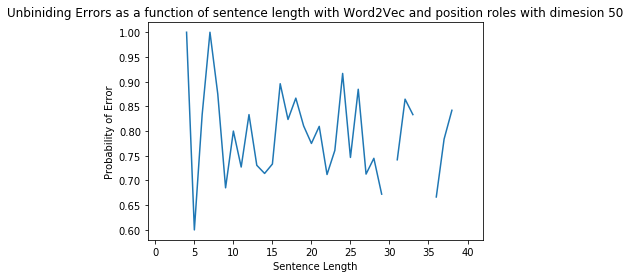

CPU times: user 36min 8s, sys: 3.69 s, total: 36min 11s
Wall time: 36min 16s


In [166]:
%%time
nfilledroles = np.array(range(1,50))
#errors = errors / nsamples
cerrors = np.zeros(49)
for i, sent in enumerate(sents[::500]):
    for j, word in enumerate(sent):
        found = False
        for v in bests[i][j]:
            if np.array_equal(wordvecs[word], v):
                found = True
        if not found:
            cerrors[len(sent)-1] += 1 / len(sent)
num_sents_per_len = [sum(1 if len(sent)==i else 0 for sent in sents[::500]) for i in range(1,50)]

percent_error = cerrors / num_sents_per_len


#inspect errors
# check one-hot

plt.plot(nfilledroles,percent_error)
plt.title('Unbiniding Errors as a function of sentence length with Word2Vec and position roles with dimesion %d' % (ndim))
plt.xlabel('Sentence Length')
plt.ylabel('Probability of Error')
plt.show()

In [114]:
s = sents[::500][98]
semb = [wordvecs[s[i]] for i in range(len(s))]
print(np.inner(semb[0],bests[98][0][6]))


2.6245756


In [24]:
    print("Downloading corpus and nltk tools, if necessary.")
    import nltk
    import gensim
    from gensim.models import KeyedVectors

    nltk.download("reuters")
    nltk.download("punkt")

    print("Beginning preprocessing...")
    from nltk.corpus import reuters

    sents = list(reuters.sents())
    print("Getting sentences of length 50 or less.")
    sents.sort(key=len)
    bound = 0
    while len(sents[bound + 1]) <= 50:
        bound += 1
    # constrain upper length of sentences to have a fixed role set.
    sents = sents[:bound]  # the sentences of length 50 or less

    # print('Removing sentences of length 0.')
    len0sents = []
    for i, sent in enumerate(sents):
        if len(sent) == 0:
            len0sents.append(sent)
        else:
            sents[i] = [word.lower() for word in sent]
    for sent in len0sents:
        sents.remove(sent)
    print("%d sentences." % (len(sents)))
    num_sents_per_len = [
        sum(1 if len(sent) == i else 0 for sent in sents) for i in range(1, 50)
    ]
    print(num_sents_per_len)

    try:
        wv = KeyedVectors.load("reuters.wv", mmap="r")
        print("Pretrained wordvectors loaded.")
    except:
        print("Training word2vec model.")
        model = gensim.models.Word2Vec(sents, size=300, min_count=1, workers=4)
        print("Word2Vec training complete!")
        model.wv.save("reuters.wv")
        wv = model.wv

    print("Beginning experiment...")
    error_prob = np.zeros(49)
    # error_prob_topk = np.zeros(49)
    nsamples = 1
    sents.sort(key=len)
    breaks = [i for i in range(1, len(sents)) if len(sents[i]) != len(sents[i - 1])]
    fillerbank = torch.from_numpy(wv.vectors.T)
    roledim = 100

[nltk_data] Error loading reuters: HTTP Error 500: Internal Server
[nltk_data]     Error
[nltk_data] Error loading punkt: HTTP Error 500: Internal Server Error


Beginning preprocessing...
Getting sentences of length 50 or less.
49442 sentences.
[42, 68, 63, 281, 205, 259, 288, 463, 535, 745, 876, 976, 1088, 1199, 1125, 1271, 1381, 1431, 1455, 1454, 1445, 1497, 1615, 1604, 1641, 1469, 1418, 1501, 1534, 1532, 1387, 1393, 1366, 1228, 1254, 1181, 1216, 1104, 994, 993, 929, 834, 852, 789, 751, 657, 592, 495, 503]
Pretrained wordvectors loaded.
Beginning experiment...


In [63]:
error = np.zeros(50)
# try random filler vecs with sentences
# sanity check with orthonormal
# try word2vec from big pretrained, constrained vocab
# bigger filler vector size, bigger role vector size
for i, brk in enumerate(breaks):
    rhats = torch_sample_spherical(
        npoints=50, ndim=roledim, nsamples=nsamples
    )
    if i == 0:
        to_process = sents[:brk]
    else:
        to_process = sents[breaks[i - 1] : brk]
    nbindings = len(to_process[0])
    sents.sort(key=len)
    fillervecs = (
        torch.stack(
            [
                torch.stack(
                    [torch.from_numpy(wv[sent[j]]) for j in range(nbindings)], dim=1
                )
                for sent in to_process
            ],
            dim=2,
        )
        .unsqueeze(-1)
        .expand(-1, -1, -1, nsamples)
    )
    x = torch.load(f'tops_word2vec_len{i}.pt')
    topk = torch.topk(x, 25, dim=0)
    topkvecs = torch.gather(fillerbank.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(-1, -1, nbindings, len(to_process), nsamples), 1, topk.indices.unsqueeze(0).expand(300, -1, -1, -1, -1))
    intopk = torch.min(torch.abs(torch.sum(topkvecs - fillervecs.unsqueeze(1).expand(-1, 25, -1, -1, -1), dim=0)), dim=0)
    error[i] = len(intopk.values.nonzero()) / intopk.values.numel()
    print(error[i])
    

0.4523809523809524
0.4117647058823529
0.3915343915343915
0.1103202846975089
0.23512195121951218
0.2059202059202059
0.2638888888888889
0.2629589632829374
0.27372793354101765
0.27758389261744965
0.25612287256122873
0.2529883879781421
0.26689762443438914
0.2656976051471464
0.2580148148148148
0.2511801730920535
0.2526302338458917
0.2637627144964671
0.2616748055706276
0.26623108665749656
0.260306475531389
0.26049067832634965
0.25925427379189664
0.25667601828761427
0.2575258988421694
0.26017175472587317
0.2666509951418273
0.2719139621204911
0.26558917412219574
0.26781984334203657
0.27427494941507546
0.2728822684852836
0.27483473091086563
0.26975953247748613
0.27017543859649124
0.2722034057766488
0.277071479374111
0.270976353928299
0.2866945261311459
0.2787260825780463
0.2800283546430728
0.2728959689391344
0.2796156785675292
0.2787187463993548
0.289273561177689
0.271954205545629
0.2737924094307073
0.27584175084175083
0.28822980484440297


In [64]:
error1 = np.zeros(50)
for i, brk in enumerate(breaks):
    rhats = torch_sample_spherical(
        npoints=50, ndim=roledim, nsamples=nsamples
    )
    if i == 0:
        to_process = sents[:brk]
    else:
        to_process = sents[breaks[i - 1] : brk]
    nbindings = len(to_process[0])
    sents.sort(key=len)
    fillervecs = (
        torch.stack(
            [
                torch.stack(
                    [torch.from_numpy(wv[sent[j]]) for j in range(nbindings)], dim=1
                )
                for sent in to_process
            ],
            dim=2,
        )
        .unsqueeze(-1)
        .expand(-1, -1, -1, nsamples)
    )
    x = torch.load(f'tops_word2vec_len{i}.pt')
    topk = torch.topk(x, 2000, dim=0)
    topkvecs = torch.gather(fillerbank.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(-1, -1, nbindings, len(to_process), nsamples), 1, topk.indices.unsqueeze(0).expand(300, -1, -1, -1, -1))
    intopk = torch.min(torch.abs(torch.sum(topkvecs - fillervecs.unsqueeze(1).expand(-1, 2000, -1, -1, -1), dim=0)), dim=0)
    error1[i] = len(intopk.values.nonzero()) / intopk.values.numel()
    print(error1[i])

0.023809523809523808
0.08823529411764706
0.1746031746031746
0.013345195729537367
0.05853658536585366
0.05148005148005148
0.07341269841269842


KeyboardInterrupt: 

In [ ]:
x = torch.load('tops_word2vec_len1.pt')

In [37]:
topk = torch.topk(x, 25, dim=0)
print(topk.indices[0].shape)

torch.Size([2, 68, 1])


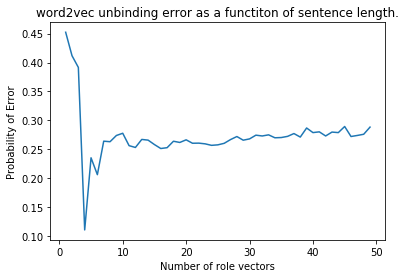

In [67]:
x1 = np.array(range(1,50))
plt.plot(x1,error[:49])
plt.title('word2vec unbinding error as a functiton of sentence length.')
plt.xlabel('Number of role vectors')
plt.ylabel('Probability of Error')
plt.show()

Text(0,0.5,'Probability of Error')

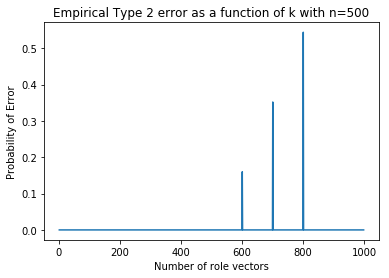

In [17]:
plt.plot(x1,y1*8)
plt.title('Empirical Type 2 error as a function of k with n=500')
plt.xlabel('Number of role vectors')
plt.ylabel('Probability of Error')